# Jimmy 24 25 sreamlit app and analysis

In [1]:
# --- Import Libraries ---
import urllib.request
from bs4 import BeautifulSoup
from selenium import webdriver
import time
import pandas as pd
import numpy as np
import os # Added for file existence checks

#from gspread import gspread
#from df2gspread import df2gspread as d2g
#from oauth2client.service_account import ServiceAccountCredentials

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.firefox.options import Options

In [3]:
## --- Configuration ---
# 1. SET THIS VALUE: Update this to the *most recent* gameweek that has been fully completed.
CURRENT_FINISHED_GW = 26  # Example: Set to 7 if Gameweek 7 just finished

# 2. Define file paths
RAW_DATA_FILE = 'raw_fantasy_data.csv'       # Stores all raw scraped data (results + fixtures)
PROCESSED_DATA_FILE = 'final_df.csv'         # Your final processed results file
FIXTURES_FILE = 'fixtures.csv'               # Your final processed fixtures file

# 3. Define total gameweeks in the season (e.g., 0-36 for 37 weeks)
TOTAL_GAMEWEEKS_RANGE = range(0, 37)

## --- Load Existing Data to Find Starting Point ---
last_processed_gw = -1
if os.path.exists(PROCESSED_DATA_FILE):
    try:
        processed_df = pd.read_csv(PROCESSED_DATA_FILE)
        if not processed_df.empty:
            last_processed_gw = processed_df['Gameweek'].max()
            print(f"Loaded '{PROCESSED_DATA_FILE}'. Last processed gameweek: {last_processed_gw}")
        else:
            print(f"'{PROCESSED_DATA_FILE}' is empty.")
    except pd.errors.EmptyDataError:
        print(f"'{PROCESSED_DATA_FILE}' exists but is empty.")
else:
    print(f"'{PROCESSED_DATA_FILE}' not found. Will start from scratch.")


## --- Load Raw Data Cache & Determine Scrape Range ---
raw_df_cache = pd.DataFrame()
gameweeks_to_scrape = []

if not os.path.exists(RAW_DATA_FILE):
    # FIRST RUN EVER: Raw file doesn't exist, must scrape everything.
    print(f"'{RAW_DATA_FILE}' not found. Performing full scrape for all gameweeks: {list(TOTAL_GAMEWEEKS_RANGE)}")
    gameweeks_to_scrape = TOTAL_GAMEWEEKS_RANGE
else:
    # SUBSEQUENT RUN: Raw file exists, load it.
    try:
        raw_df_cache = pd.read_csv(RAW_DATA_FILE)
        if not raw_df_cache.empty:
            print(f"Loaded raw data cache from '{RAW_DATA_FILE}'.")
        
            # Calculate *only* the new gameweeks that have finished since our last run.
            # e.g., last_processed_gw = 6, CURRENT_FINISHED_GW = 7. Scrape range(7, 8).
            # e.g., last_processed_gw = 3, CURRENT_FINISHED_GW = 7. Scrape range(4, 8).
            gameweeks_to_scrape = range(last_processed_gw + 1, CURRENT_FINISHED_GW + 1)
            
            if not list(gameweeks_to_scrape):
                print("All processed gameweeks are already up-to-date with finished gameweek.")
                print("No new results to scrape.")
            else:
                print(f"Will scrape *only* new results for gameweeks: {list(gameweeks_to_scrape)}")

        else:
            # Cache file is empty, treat as a first run.
            print(f"'{RAW_DATA_FILE}' is empty. Performing full scrape: {list(TOTAL_GAMEWEEKS_RANGE)}")
            gameweeks_to_scrape = TOTAL_GAMEWEEKS_RANGE
            
    except pd.errors.EmptyDataError:
        # Cache file is unreadable, treat as a first run.
        print(f"'{RAW_DATA_FILE}' is empty. Performing full scrape: {list(TOTAL_GAMEWEEKS_RANGE)}")
        gameweeks_to_scrape = TOTAL_GAMEWEEKS_RANGE


# This variable is used by your later processing cells
finished_gw = CURRENT_FINISHED_GW

Loaded 'final_df.csv'. Last processed gameweek: 24
Loaded raw data cache from 'raw_fantasy_data.csv'.
Will scrape *only* new results for gameweeks: [25, 26]


In [4]:
# --- Firefox Options ---
options = Options()
options.set_preference("general.useragent.override", "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36")
# You can add options.add_argument("-headless") here if you don't want the browser window to open

# --- Scraper Function (Unchanged) ---
def scrape_gameweek_data(driver, gameweek):
    url = f'https://app.draftfantasy.com/league/cmdyldh61003ll504ahnjk58j/matches?gameweek={gameweek}'
    driver.get(url)
    
    # Wait for the page to load
    time.sleep(2) 
    
    # Get page source and parse with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    # Find the table
    table = soup.find('table')
    
    if table:
        # Extract data into a DataFrame
        headers = [header.text for header in table.find_all('th')]
        rows = []
        for row in table.find_all('tr')[1:]:
            rows.append([cell.text for cell in row.find_all('td')])
        
        df = pd.DataFrame(rows, columns=headers)
        return df
    else:
        print(f"No table found for gameweek {gameweek}")
        return pd.DataFrame()  # Return empty DataFrame if no table is found

In [5]:
new_data_list = []
final_df = pd.DataFrame() # This will hold our complete raw dataset

# Only run the browser if we actually need to scrape
if list(gameweeks_to_scrape):
    print("Initializing browser for scraping...")
    driver = webdriver.Firefox(options=options) # 'options' is from Cell 3

    try:
        # --- Login Logic ---
        driver.get('https://app.draftfantasy.com/league/cmdyldh61003ll504ahnjk58j/matches?gameweek=1')
        try:
            WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.XPATH, '//input[@name="email"]'))
            ).send_keys('andy.uttley@gmail.com')
            
            WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.XPATH, '//input[@name="password"]'))
            ).send_keys('C@vendish220988') # !! REMEMBER TO REPLACE 'fakepassword' !!
            
            login_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, '//button[text()="Sign In"]'))
            )
            login_button.click()
            print("Login successful.")
            
        except TimeoutException:
            print("Element not found or took too long to load during login.")
            driver.quit()
            raise Exception("Login Failed. Stopping script.")

        # Wait for the page to load completely after login
        time.sleep(2)

        # --- Efficient Scraping Loop ---
        print(f"Starting to scrape {len(list(gameweeks_to_scrape))} gameweeks...")
        for gameweek in gameweeks_to_scrape:
            print(f"Scraping Gameweek {gameweek}...")
            df = scrape_gameweek_data(driver, gameweek)
            if not df.empty:
                df['Gameweek'] = gameweek  # Add gameweek identifier
                new_data_list.append(df)

        print("Scraping complete.")
        
    finally:
        # Always close the browser
        driver.quit()
        print("Browser closed.")

    # --- Combine and Save Raw Data ---
    if new_data_list:
        new_data_df = pd.concat(new_data_list, ignore_index=True)
        
        # Combine with the *full* cache (which has old results + future fixtures)
        final_df = pd.concat([raw_df_cache, new_data_df], ignore_index=True)
        
        # *** KEY STEP: Replace old fixture data with new results data ***
        # This drops old rows for the gameweeks we just scraped, keeping the new ones.
        # e.g., it drops GW7 "fixture" and keeps GW7 "result"
        # It leaves all other rows (0-6 results, 8-36 fixtures) untouched.
        final_df = final_df.drop_duplicates(subset=['Gameweek', 'Home'], keep='last')
        final_df = final_df.sort_values('Gameweek').reset_index(drop=True)
        
        print(f"New data merged with cache. Total raw rows: {len(final_df)}")
    else:
        print("No new data was successfully scraped.")
        final_df = raw_df_cache.copy() # Use the old data

    # Save the *full* updated dataset back to our cache
    final_df.to_csv(RAW_DATA_FILE, index=False)
    print(f"Updated raw data cache saved to '{RAW_DATA_FILE}'.")

else:
    print("Skipping login and scraping. Using data from cache.")
    final_df = raw_df_cache.copy() # Use the data we loaded in Cell 2

# Display the head of the raw data
(final_df.head())

Initializing browser for scraping...
Login successful.
Starting to scrape 2 gameweeks...
Scraping Gameweek 25...
Scraping Gameweek 26...
Scraping complete.
Browser closed.
New data merged with cache. Total raw rows: 180
Updated raw data cache saved to 'raw_fantasy_data.csv'.


,Home,vs,Away,Gameweek
0,Farke The BusMikey Wade,44 - 41,Fish⭐⭐⭐⭐,1
1,In Dulcis Larkus SCCEd Dove,58 - 36,Shearer's Shiny SlabSam Watkinson,1
2,ManeBall ⭐⭐⭐Andy Uttley,39 - 32,Son but not forgottenMike Fill,1
3,I've abandoned my Son!John Marsh,57 - 33,Cunha Mateta ⭐️⭐️Tim Boorman,1
4,Settlers of ZlatanKarl Webster,67 - 32,Brain Potter’s XI ⭐️Matt Warmoth,1


In [6]:
# Rename teams to people
# This is more efficient than multiple .apply() calls
team_to_player_map = {
    "Marsh": "John",
    "Dove": "Dove",
    "Fish": "Nick",
    "Fill": "Mike",
    "Uttley": "Andy",
    "Boorman": "Tim",
    "Watkinson": "Sam",
    "Wade": "Mikey",
    "Matt": "Matt",
    "Webster": "Karl"
}

# Create a function to apply the mapping
def map_name(team_name):
    if not isinstance(team_name, str):
        return team_name # Handle non-string values
    for key, value in team_to_player_map.items():
        if key in team_name:
            return value
    return team_name # Return original if no match

# Apply the mapping function
final_df['Home'] = final_df['Home'].apply(map_name)
final_df['Away'] = final_df['Away'].apply(map_name)

print("Team names renamed to player names.")
(final_df.head())

Team names renamed to player names.


,Home,vs,Away,Gameweek
0,Mikey,44 - 41,Nick,1
1,Dove,58 - 36,Sam,1
2,Andy,39 - 32,Mike,1
3,John,57 - 33,Tim,1
4,Karl,67 - 32,Matt,1


In [7]:
# Split final_df into played (final_df_filtered) and not played (fixtures_df)
# Uses the 'finished_gw' variable set in Cell 2

# Add .copy() to avoid SettingWithCopyWarning in the next cell
final_df_filtered = final_df[final_df['Gameweek'] <= finished_gw].copy()
fixtures_df = final_df[final_df['Gameweek'] > finished_gw].copy()

# The user's script re-assigns final_df. We'll do the same.
final_df = final_df_filtered

print(f"Split data: {len(final_df)} played matches (up to GW {finished_gw}), {len(fixtures_df)} future fixtures.")
(final_df.head())

Split data: 130 played matches (up to GW 26), 50 future fixtures.


,Home,vs,Away,Gameweek
0,Mikey,44 - 41,Nick,1
1,Dove,58 - 36,Sam,1
2,Andy,39 - 32,Mike,1
3,John,57 - 33,Tim,1
4,Karl,67 - 32,Matt,1


In [8]:
# Create a list to store the expanded rows
expanded_rows = []

# Loop through each row and add two rows for each game
for index, row in final_df.iterrows():
    
    # --- Refinement: Add error handling for missing/invalid scores ---
    if not isinstance(row['vs'], str) or ' - ' not in row['vs']:
        print(f"Skipping row for GW {row['Gameweek']} (Home: {row['Home']}) - 'vs' column is invalid: {row['vs']}")
        continue
    # --- End Refinement ---

    try:
        # Split the score into two parts
        player_score, opponent_score = map(int, row['vs'].split(' - '))
    except ValueError:
        print(f"Skipping row for GW {row['Gameweek']} (Home: {row['Home']}) - 'vs' column not parsable: {row['vs']}")
        continue

    # Determine the result and table points
    if player_score > opponent_score:
        result = 'Win'
        table_points = 3
    elif player_score < opponent_score:
        result = 'Lose'
        table_points = 0
    else:
        result = 'Draw'
        table_points = 1
    
    # Append first player's data
    expanded_rows.append({
        'Player': row['Home'],
        'Opponent': row['Away'],
        'Player_Score': player_score,
        'Opponent_Score': opponent_score,
        'Result': result,
        'Table Points': table_points,
        'Gameweek': row['Gameweek']
    })
    
    # Determine the reverse result
    if result == 'Win':
        opponent_result = 'Lose'
        opponent_table_points = 0
    elif result == 'Lose':
        opponent_result = 'Win'
        opponent_table_points = 3
    else:
        opponent_result = 'Draw'
        opponent_table_points = 1
    
    # Append second player's data
    expanded_rows.append({
        'Player': row['Away'],
        'Opponent': row['Home'],
        'Player_Score': opponent_score,
        'Opponent_Score': player_score,
        'Result': opponent_result,
        'Table Points': opponent_table_points,
        'Gameweek': row['Gameweek']
    })

# Create a new DataFrame from the expanded rows
if expanded_rows: # Only proceed if we have valid data
    expanded_df = pd.DataFrame(expanded_rows)

    # Calculate the gameweek rank based on Player_Score
    expanded_df['GW Rank'] = expanded_df.groupby('Gameweek')['Player_Score'].rank(ascending=False, method='min')

    # Calculate luck points based on GW Rank
    expanded_df['Luck Points'] = expanded_df['GW Rank'].apply(lambda rank: 3 if rank <= 4 else (1 if rank <= 6 else 0))

    # Re-assign as per user's script
    final_df = expanded_df
    print("Processed results dataframe created.")
    (final_df.head())
else:
    print("No valid played games found to process.")
    final_df = pd.DataFrame() # Create empty df to avoid errors in the next cell

Processed results dataframe created.


In [9]:
# Save the *processed* results data
if not final_df.empty:
    final_df.to_csv(PROCESSED_DATA_FILE, index=False)
    print(f"Processed results saved to '{PROCESSED_DATA_FILE}'")
else:
    print("No processed results to save.")

Processed results saved to 'final_df.csv'


In [10]:
# Remake fixtures table
if not fixtures_df.empty:
    # Drop the 'vs' column (it's likely empty or just 'vs')
    if 'vs' in fixtures_df.columns:
        fixtures_df = fixtures_df.drop(columns=['vs'])

    expanded_rows = []
    for index, row in fixtures_df.iterrows():
        expanded_rows.append({
            'Player': row['Home'],
            'Opponent': row['Away'],
            'Gameweek': row['Gameweek']
        })
        expanded_rows.append({
            'Player': row['Away'],
            'Opponent': row['Home'],
            'Gameweek': row['Gameweek']
        })

    expanded_fixtures_df = pd.DataFrame(expanded_rows)
    fixtures = expanded_fixtures_df
    
    # Save the processed fixtures
    fixtures.to_csv(FIXTURES_FILE, index=False)
    print(f"Processed fixtures saved to '{FIXTURES_FILE}'")
    (fixtures.head())
else:
    print("No fixtures to process or save.")

Processed fixtures saved to 'fixtures.csv'


In [11]:
final_df

,Player,Opponent,Player_Score,Opponent_Score,Result,Table Points,Gameweek,GW Rank,Luck Points
0,Mikey,Nick,44,41,Win,3,1,4.0,3
1,Nick,Mikey,41,44,Lose,0,1,5.0,1
2,Dove,Sam,58,36,Win,3,1,2.0,3
3,Sam,Dove,36,58,Lose,0,1,7.0,0
4,Andy,Mike,39,32,Win,3,1,6.0,1
...,...,...,...,...,...,...,...,...,...
255,Sam,Mikey,48,54,Lose,0,26,4.0,3
256,Andy,Matt,53,33,Win,3,26,2.0,3
257,Matt,Andy,33,53,Lose,0,26,8.0,0
258,Dove,Mike,34,27,Win,3,26,7.0,0


In [ ]:
################ sim and stats CODE #################

Matplotlib is building the font cache; this may take a moment.


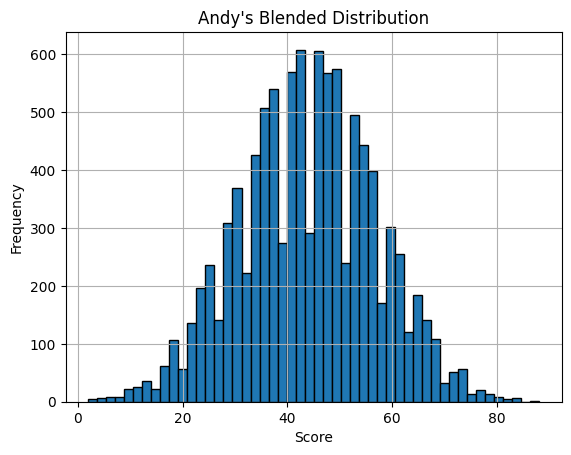

In [20]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

# Compute global league mean and std from ALL player scores
all_scores = final_df['Player_Score']
league_mean = all_scores.mean()
league_std = all_scores.std()

# Decide on a weight w based on number of games played so far
max_gameweek = final_df['Gameweek'].max()
w = 0.5 if max_gameweek < 20 else 0.8  # Just an example heuristic

player_stats = final_df.groupby('Player')['Player_Score'].agg(['mean', 'std', 'count']).reset_index()
player_stats = player_stats.rename(columns={
    'mean': 'mean_score',
    'std': 'std_dev',
    'count': 'games_played'
})

score_distributions = {}
extension_factor = 0.5  # how much to extend beyond observed extremes

for _, row in player_stats.iterrows():
    player = row['Player']
    mean_p = row['mean_score']
    std_p = row['std_dev']
    count_p = row['games_played']

    # If player's std_dev is NaN or 0 (no variation so far), set a minimum std_dev
    if np.isnan(std_p) or std_p == 0:
        std_p = league_std  # or some small fraction of league_std if you'd prefer

    # Blend player stats with league stats
    player_mean_final = w * mean_p + (1 - w) * league_mean
    player_std_final = w * std_p + (1 - w) * league_std

    # Determine truncation bounds
    low = max(0, player_mean_final - player_std_final * (3 + extension_factor))
    high = min(100, player_mean_final + player_std_final * (3 + extension_factor))

    # Ensure low < high
    if low >= high:
        low = max(0, league_mean - 3*league_std)
        high = min(100, league_mean + 3*league_std)

    a = (low - player_mean_final) / player_std_final
    b = (high - player_mean_final) / player_std_final

    truncated_dist = truncnorm(a, b, loc=player_mean_final, scale=player_std_final)
    scores = truncated_dist.rvs(10000)

    # Round to nearest integer
    scores = np.rint(scores)
    # Clip final scores to [0, 100], just to be safe
    scores = np.clip(scores, 0, 100)

    score_distributions[player] = scores

# Optional: Check distribution shape for a specific player
player_to_check = list(score_distributions.keys())[0]
plt.hist(score_distributions[player_to_check], bins=50, edgecolor='black')
plt.title(f"{player_to_check}'s Blended Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [21]:
def simulate_season(final_df, fixtures, score_distributions, num_simulations):
    granular_results = []
    
    # --- Pre-simulation setup ---
    finished_gw = final_df['Gameweek'].max()
    
    # Calculate initial points and scores from the final_df
    # This is our "starting line" for the simulation
    initial_table = final_df.groupby('Player', as_index=False).agg(
        {'Table Points': 'sum', 'Player_Score': 'sum'}
    )
    initial_table['Player_Score'] = initial_table['Player_Score'].astype(float)
    
    # Calculate max possible points for each player (for error checking)
    known_points = initial_table.set_index('Player')['Table Points']
    remaining_games = fixtures[fixtures['Gameweek'] > finished_gw]['Gameweek'].nunique()
    max_points_per_player = known_points + (remaining_games * 3)

    # Create a unique match key to avoid double counting
    fixtures['MatchKey'] = fixtures.apply(
        lambda x: (x['Gameweek'], tuple(sorted([x['Player'], x['Opponent']]))),
        axis=1
    )
    
    # Filter remaining fixtures and remove duplicates by MatchKey
    # This only needs to be done *once*, outside the simulation loop
    remaining_fixtures = fixtures[fixtures['Gameweek'] > finished_gw].drop_duplicates(subset=['MatchKey'])

    # --- Start Simulations ---
    for sim in range(num_simulations):
        
        # *** SPEED OPTIMIZATION ***
        # Instead of a DataFrame, use dictionaries for fast lookups
        sim_points = initial_table.set_index('Player')['Table Points'].to_dict()
        sim_scores = initial_table.set_index('Player')['Player_Score'].to_dict()
        # *** END OPTIMIZATION ***

        for _, fixture in remaining_fixtures.iterrows():
            player, opponent = fixture['Player'], fixture['Opponent']
            
            # Simulation logic is UNCHANGED
            player_score = np.random.choice(score_distributions[player])
            opponent_score = np.random.choice(score_distributions[opponent])

            # *** SPEED OPTIMIZATION ***
            # Update the dictionaries instead of using slow .loc lookups
            if player_score > opponent_score:
                sim_points[player] += 3
            elif player_score < opponent_score:
                sim_points[opponent] += 3
            else:
                sim_points[player] += 1
                sim_points[opponent] += 1

            # Update Player Scores
            sim_scores[player] += player_score
            sim_scores[opponent] += opponent_score
            # *** END OPTIMIZATION ***

        # --- Post-simulation processing (for this single sim) ---
        
        # *** SPEED OPTIMIZATION ***
        # Convert dictionaries back to a DataFrame *once*
        sim_table = pd.DataFrame.from_dict(sim_points, orient='index', columns=['Table Points'])
        sim_table['Player_Score'] = pd.Series(sim_scores)
        sim_table = sim_table.reset_index().rename(columns={'index': 'Player'})
        # *** END OPTIMIZATION ***

        # Check if any player exceeds max points (your original check)
        for _, row in sim_table.iterrows():
            if row['Table Points'] > max_points_per_player[row['Player']]:
                raise ValueError(f"Player {row['Player']} exceeds maximum possible points in simulation {sim}.")

        # Sort and rank players
        sim_table = sim_table.sort_values(by=['Table Points', 'Player_Score'], ascending=[False, False])
        sim_table['Rank'] = range(1, len(sim_table) + 1)
        sim_table['Simulation'] = sim

        granular_results.append(sim_table)

        if (sim + 1) % 100 == 0: # Changed to every 100 as it will be faster
            print(f"Finished sim {sim+1} / {num_simulations}")

    # --- Final Analysis (outside simulation loop) ---
    
    # Combine all results into a single dataframe
    granular_results = pd.concat(granular_results, ignore_index=True)

    # Calculate finishing position percentages
    finishing_positions = granular_results.groupby(['Player', 'Rank']).size().unstack(fill_value=0)
    finishing_positions = finishing_positions.div(finishing_positions.sum(axis=1), axis=0) * 100
    finishing_positions = finishing_positions.round(1)

    # Sort by column '1' (and subsequently by '2', '3', etc.)
    sort_cols = sorted(list(finishing_positions.columns))
    finishing_positions = finishing_positions.sort_values(by=sort_cols, ascending=False)

    
    # Calculate top 4 odds
    top_4_odds = granular_results[granular_results['Rank'] <= 4].groupby('Player')['Rank'].count()
    top_4_odds = (top_4_odds / num_simulations * 100).reset_index()
    top_4_odds.columns = ['Player', 'Top 4 %']

    # --- Odds calculation functions (Unchanged) ---
    def probability_to_odds(p):
        if p == 1.0:
            return "1/999", -99999
        elif p == 0.0:
            return "999/1", 99999
        
        fraction = (1 - p) / p
        if fraction >= 1:
            frac_odds = f"{int(round(fraction))}/1"
        else:
            inv = 1 / fraction
            frac_odds = f"1/{int(round(inv))}"
        
        if p > 0.5:
            american = -int(round(100 * p / (1 - p)))
        else:
            american = int(round(100 * (1 - p) / p))
        
        return frac_odds, american

    # --- Apply odds calculations (Unchanged) ---
    top_4_odds['Fractional Odds'] = ""
    top_4_odds['American Odds'] = 0

    for i, row in top_4_odds.iterrows():
        p = row['Top 4 %'] / 100.0
        frac, am = probability_to_odds(p)
        top_4_odds.at[i, 'Fractional Odds'] = frac
        top_4_odds.at[i, 'American Odds'] = am

    top_4_odds = top_4_odds.sort_values(by='Top 4 %', ascending=False)
    
    # --- History File Logic (Unchanged) ---
    top_4_odds['as of finished_gw'] = finished_gw
    history_filename = "top_4_odds_history.csv"
    try:
        top_4_history = pd.read_csv(history_filename)
    except FileNotFoundError:
        top_4_history = pd.DataFrame()
    
    if not top_4_history.empty:
        top_4_history = top_4_history[top_4_history['as of finished_gw'] != finished_gw]
    
    top_4_history = pd.concat([top_4_history, top_4_odds], ignore_index=True)
    top_4_history = top_4_history.sort_values(by='as of finished_gw', ascending=False)
    top_4_history.to_csv(history_filename, index=False)
    
    # --- Create distribution charts (Unchanged) ---
    players = granular_results['Player'].unique()
    for player in players:
        player_points = granular_results.loc[granular_results['Player'] == player, 'Table Points']
    
        plt.figure()
        plt.hist(player_points, bins=15, edgecolor='black', alpha=0.7)
        plt.title(f"Distribution of Table Points for {player}")
        plt.xlabel("Table Points")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.savefig(f"{player}_table_points_distribution.png")
        plt.close() # Use plt.close() instead of plt.show() to prevent popups
    
    print("Finished creating player distribution charts.")
    return granular_results, finishing_positions, top_4_odds

In [ ]:
# Run the simulation (adjust num_simulations as needed)
num_simulations = 1000 # You can likely increase this now
granular_results, finishing_positions, top_4_odds = simulate_season(final_df, fixtures, score_distributions, num_simulations)

# Save results
granular_results.to_csv("granular_results.csv", index=False)
finishing_positions.to_csv("finishing_positions.csv")
top_4_odds = top_4_odds.sort_values(by='Top 4 %', ascending=False)
top_4_odds.to_csv("top_4_odds.csv", index=False)
#store distros as a file for streamlit
pd.to_pickle(score_distributions, "score_distributions.pkl")

print("Granular Results Saved: granular_results.csv")
print("Finishing Positions Saved: finishing_positions.csv")
print("Top 4 Odds Saved: top_4_odds.csv")
print("Distributions Saved: score_distributions.pkl")

In [ ]:
# Print the first 20 scores possible for 'Andy'
print("Andy's scores:", score_distributions['Andy'][:20])

#show results
granular_results.head(30)


In [ ]:
finishing_positions

In [ ]:
top_4_odds

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np

# Filter the DataFrame
filtered_df = granular_results[granular_results['Rank'] == 4]
points = filtered_df['Table Points']

# Calculate Statistics
mean_val = points.mean()
min_val = points.min()
max_val = points.max()
std_val = points.std() # Standard deviation is needed for the bell curve

print(f"Mean: {mean_val}")
print(f"Min: {min_val}")
print(f"Max: {max_val}")

# Plotting the Bell Curve
plt.figure(figsize=(10, 6))

# 1. Plot Histogram of the actual data
plt.hist(points, bins=15, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Observed Data')

# 2. Plot the Normal Distribution Curve (Bell Curve)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_val, std_val)
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution (Bell Curve)')

plt.title('Distribution of Table Points for Rank = 4')
plt.xlabel('Table Points')
plt.ylabel('Density')
plt.legend()
plt.show()